In [1]:
import numpy as np
import pandas as pd
from scipy.ndimage import convolve1d
from scipy.signal import butter, filtfilt
from matplotlib import pyplot as plt

In [2]:
dataframe = pd.read_csv('/Users/julian/Documents/daten/STUDIUM Master/FabLab 2025/Codebase/MouseMemoryGraph/data/a2024-11-01T14_30_53DLC_resnet50_fearbox_optoJan27shuffle1_100000.csv', header=1)
dataframe = dataframe.drop(dataframe.index[0])
dataframe['head_x'] = dataframe['head'].astype(float)
dataframe['head_y'] = dataframe['head.1'].astype(float)
dataframe['tail_x'] = dataframe['middle tail'].astype(float)
dataframe['tail_y'] = dataframe['middle tail.1'].astype(float)
dataframe['base_x'] = dataframe['base tail'].astype(float)
dataframe['base_y'] = dataframe['base tail.1'].astype(float)

In [3]:
def smooth_coordinates(dataframe, window_width=60):
    kernel = np.ones(window_width)
    base_convolved_x = convolve1d(dataframe['base_x'], kernel, mode='constant')
    base_convolved_y = convolve1d(dataframe['base_y'], kernel, mode='constant')
    head_convolved_x = convolve1d(dataframe['head_x'], kernel, mode='constant')
    head_convolved_y = convolve1d(dataframe['head_y'], kernel, mode='constant')
    return base_convolved_x, base_convolved_y, head_convolved_x, head_convolved_y

def calculate_velocity(convolved_x, convolved_y):
    return np.sqrt(np.diff(convolved_x)**2 + np.diff(convolved_y)**2)

def plot_velocity(velocity, color, label, title):
    plt.figure(figsize=(20, 10))
    plt.plot(velocity, color=color, label=label)
    plt.title(title)
    plt.xlabel('Time (frames)')
    plt.ylabel('Velocity (units/frame)')
    plt.legend()
    plt.show()

def detect_freezing(velocity, window_width=5, threshold=6):
    head_freezing = np.zeros(len(velocity))
    for i in range(window_width, len(velocity)):
        if velocity[max(i-(window_width//2), 0):min(i+(window_width//2), len(velocity))].mean() < threshold:
            head_freezing[i] = 1
    kernel = np.ones(10)
    head_freezing = convolve1d(head_freezing, kernel, mode='constant')
    return head_freezing > 2

def plot_freezing(velocity, head_freezing, freezing_true, title):
    plt.figure(figsize=(20, 10))
    plt.plot(velocity, color='blue', label='Velocity')
    for i in range(len(head_freezing)):
        if head_freezing[i] == 1:
            plt.axvspan(i, i+1, color='lightblue', alpha=0.3, label='Freezing Detected' if i == 0 else "")
    for i in range(len(freezing_true)):
        plt.axvspan(freezing_true[i][0], freezing_true[i][1], ymin=0.9, color='lightgreen', alpha=0.7, label='True Freezing' if i == 0 else "")
    plt.title(title)
    plt.xlabel('Time (frames)')
    plt.ylabel('Velocity (units/frame)')
    plt.legend()
    plt.show()

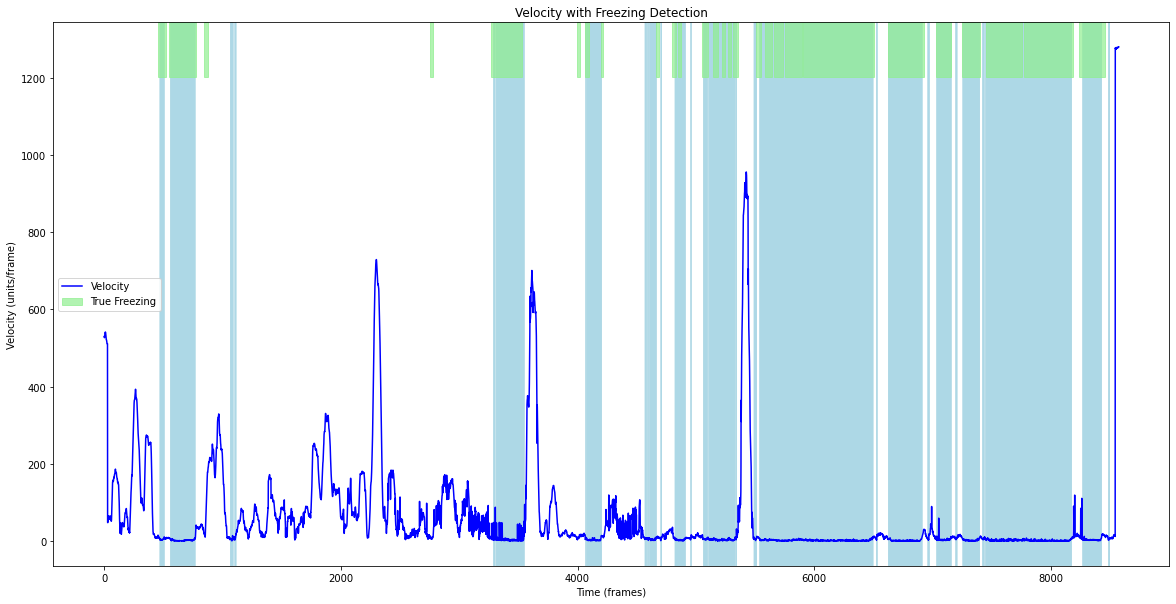

In [4]:
base_convolved_x, base_convolved_y, head_convolved_x, head_convolved_y = smooth_coordinates(dataframe)
base_velocity = calculate_velocity(base_convolved_x, base_convolved_y)
head_velocity = calculate_velocity(head_convolved_x, head_convolved_y)

velocity = (base_velocity + head_velocity) / 2
head_freezing = detect_freezing(velocity)

freezing_true = np.array([[453, 525], [545, 775], [845, 880], [2757, 2776], [3270, 3531], [3998, 4022], [4065, 4095], [4197, 4217], [4659, 4691], [4802, 4835], [4849, 4873], [5050, 5101], [5141, 5190], [5221, 5248], [5268, 5300], [5317, 5356], [5508, 5548], [5581, 5641], [5661, 5736], [5750, 5898], [5907, 6502], [6620, 6931], [7025, 7156], [7247, 7402], [7455, 7758], [7773, 8188], [8239, 8455]])

plot_freezing(velocity, head_freezing, freezing_true, 'Velocity with Freezing Detection')

In [5]:
def smooth_signal(x,window_len=10,window='flat'):

    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    The code taken from: https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
                'flat' window will produce a moving average smoothing.

    output:
        the smoothed signal        
    """

    import numpy as np

    if x.ndim != 1:
        raise(ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise(ValueError, "Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise(ValueError, "Window is one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]

    if window == 'flat': # Moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')

    return y[(int(window_len/2)-1):-int(window_len/2)]

In [6]:
# Load data
def load_photometry_data(file_path):
    df = pd.read_csv(file_path).rename(columns={
        "AIn-1 - Dem (AOut-1)": "ACC control",
        "AIn-1 - Dem (AOut-2)": "ACC 465",
    })
    return df.dropna()

# Bin data at 10ms (100Hz)
def bin_data(df, bin_size=0.01):
    df["Time_bin"] = df["Time(s)"].round(2)  # Create a new column for binning
    df_binned = df.groupby("Time_bin").agg({  # Aggregate using mean
        "ACC control": "mean",
        "ACC 465": "mean",
    }).reset_index()
    
    df_binned.rename(columns={"Time_bin": "Time(s)"}, inplace=True)  # Rename back
    return df_binned

# Apply low-pass filter at 1.7Hz
def low_pass_filter(data, cutoff=1.7, fs=100):
    nyquist = 0.5 * fs
    norm_cutoff = cutoff / nyquist
    b, a = butter(2, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Define file path
folder = '/Users/julian/Documents/daten/STUDIUM Master/FabLab 2025/raw data - 04 Feb/'  # Modify it depending on your location
file_name = 'cfc_2046.csv'  # Update to your dataset
file_path = folder + file_name

# Load and process data
df = load_photometry_data(file_path)
df = bin_data(df)  # Bin data at 10ms

# Apply low-pass filter to each signal
for col in ["ACC control", "ACC 465"]:
    df[col] = low_pass_filter(df[col])

# Display first few rows to confirm
df.head()

,Time(s),ACC control,ACC 465
0,0.12,0.514544,0.719307
1,0.13,0.514060,0.719291
2,0.14,0.513570,0.719272
3,0.15,0.513077,0.719252
4,0.16,0.512582,0.719229


In [7]:
# Adjust these lines depending on your dataframe
raw_reference = df['ACC control'][1:]
raw_signal = df['ACC 465'][1:]

smooth_win = 10
smooth_reference = smooth_signal(raw_reference, smooth_win)
smooth_signal = smooth_signal(raw_signal, smooth_win)

# Define function to compute linear baseline
def linear_baseline(signal):
    x = np.arange(len(signal))  # Create x-values (indices of the signal)
    coeffs = np.polyfit(x, signal, deg=1)  # Fit a linear function (degree 1)
    baseline = np.polyval(coeffs, x)  # Evaluate the polynomial at x
    return baseline

# Compute linear baselines
s_base = linear_baseline(smooth_signal)
r_base = linear_baseline(smooth_reference)

remove=0
reference = (smooth_reference[remove:] - r_base[remove:])
signal = (smooth_signal[remove:] - s_base[remove:])  

z_reference = (reference - np.median(reference)) / np.std(reference)
z_signal = (signal - np.median(signal)) / np.std(signal)

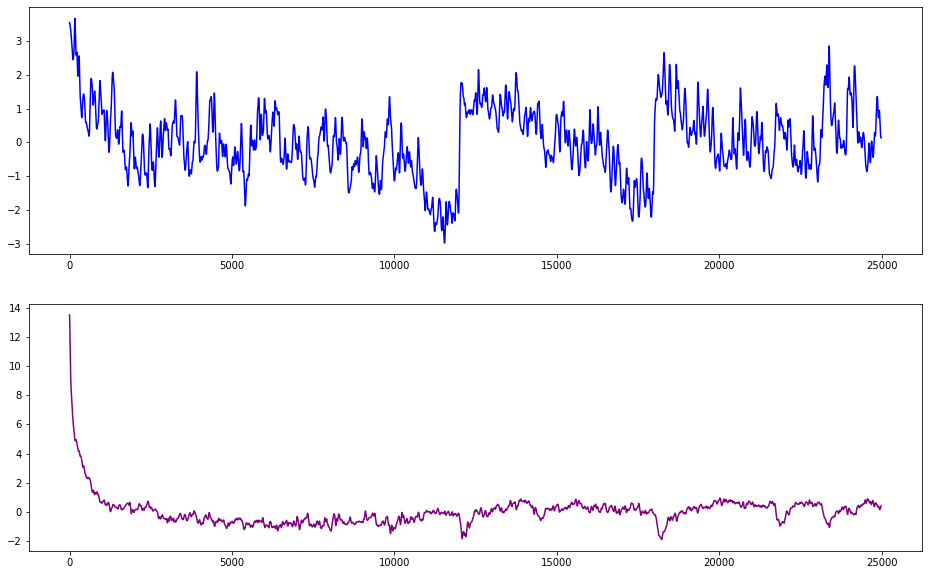

In [8]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(211)
ax1.plot(z_signal,'blue',linewidth=1.5)
ax2 = fig.add_subplot(212)
ax2.plot(z_reference,'purple',linewidth=1.5)

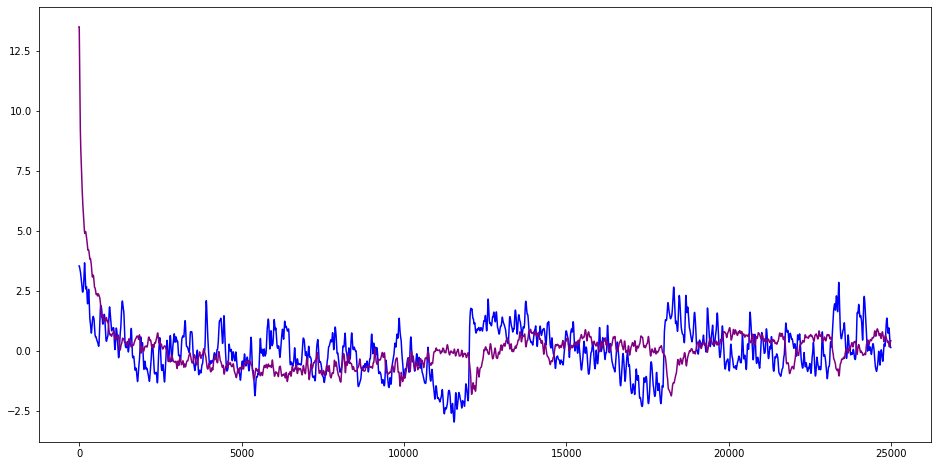

In [9]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)
ax1.plot(z_signal,'blue')
ax1.plot(z_reference,'purple')

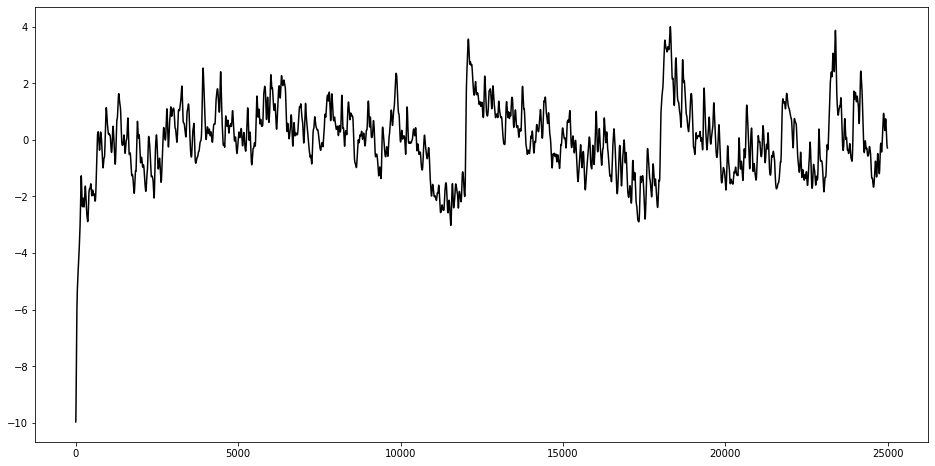

In [10]:
zdFF = (z_signal - z_reference)
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)
ax1.plot(zdFF,'black')

# Merge the freezing data with the photometry data

In [23]:
zdFF = z_signal

In [24]:
head_freezing_int = head_freezing.astype(int)

# Create an array of indices for the original head_freezing array
original_indices = np.linspace(0, len(zdFF) - 1, num=len(head_freezing))

# Create an array of indices for the target length
target_indices = np.arange(len(zdFF))

# Interpolate the integer values
interpolated_values = np.interp(target_indices, original_indices, head_freezing_int)

# Convert interpolated values back to boolean
interpolated_head_freezing = interpolated_values >= 0.5

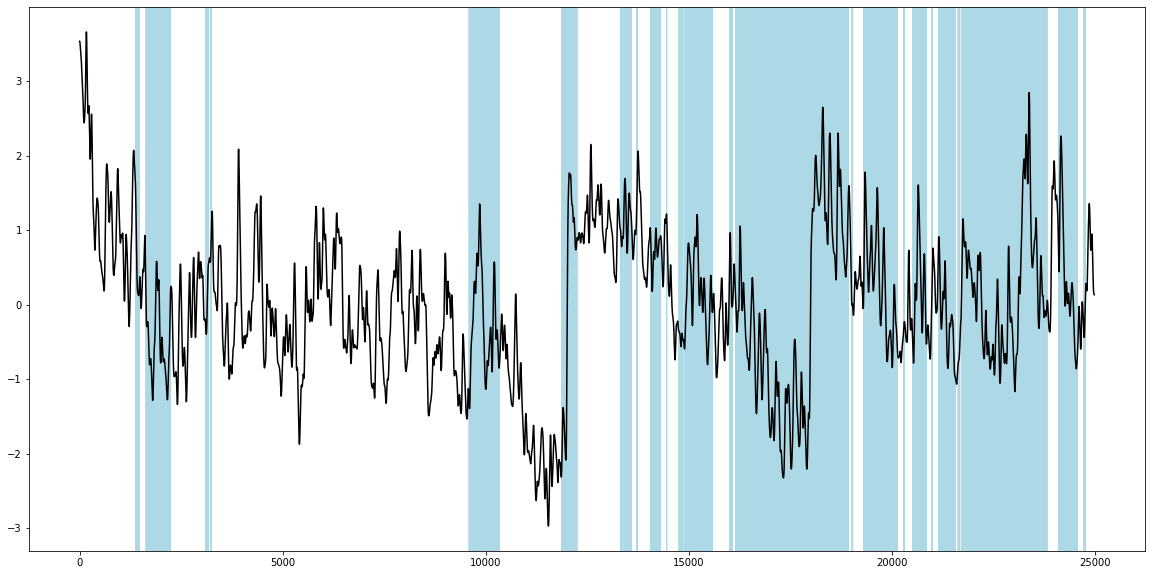

In [25]:
plt.figure(figsize=(20, 10))
plt.plot(zdFF, color='black', label='photometry signal')
for i in range(len(interpolated_head_freezing)):
    if interpolated_head_freezing[i] == 1:
        plt.axvspan(i, i+1, color='lightblue', alpha=0.3, label='Freezing Detected' if i == 0 else "")

In [26]:
# from the boolean array get the intervals of freezing

def get_intervals(x):
    s = pd.Series(x)
    grp = s.eq(False).cumsum()
    arr = grp.loc[s.eq(True)] \
            .groupby(grp) \
            .apply(lambda x: [x.index.min(), x.index.max()])
    return arr.tolist()

freezing_intervals = get_intervals(interpolated_head_freezing)

# sort intervals by length
freezing_intervals.sort(key=lambda x: x[1] - x[0])

# take the 10 longest intervals

longest_intervals = freezing_intervals[-10:]

In [27]:
longest_intervals

[[11876, 12239],
 [20489, 20852],
 [21130, 21555],
 [24083, 24557],
 [1617, 2231],
 [14872, 15536],
 [9638, 10336],
 [19297, 20135],
 [21693, 23816],
 [16129, 18926]]

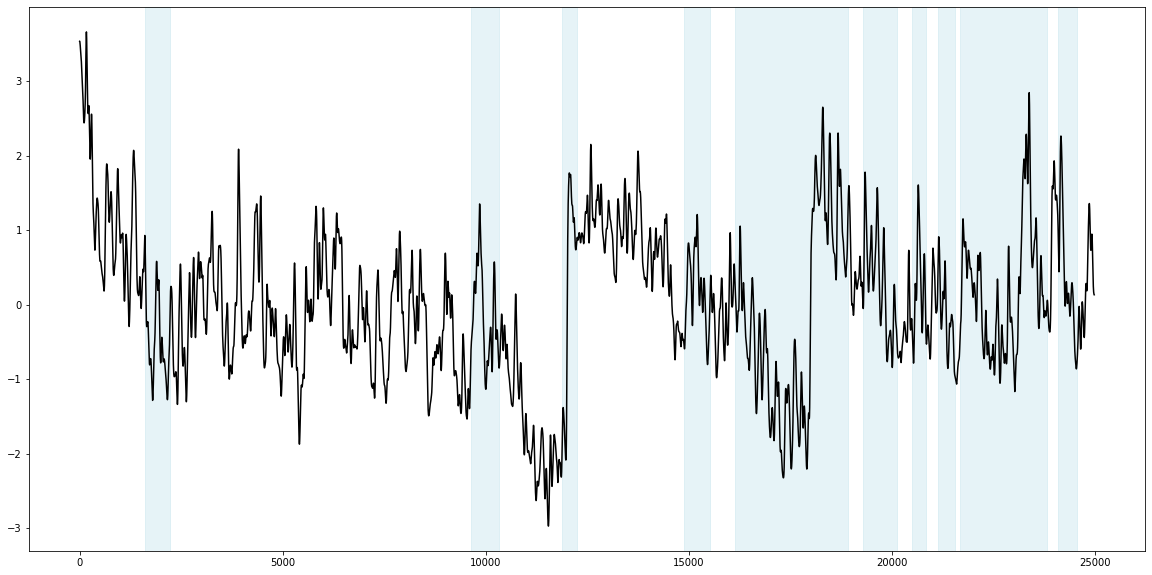

In [28]:
# plot the longest intervals
plt.figure(figsize=(20, 10))
plt.plot(zdFF, color='black', label='photometry signal')

for interval in longest_intervals:
    plt.axvspan(interval[0], interval[1], color='lightblue', alpha=0.3, label='Freezing Detected' if interval == longest_intervals[0] else "")

In [29]:
# we assume 100fps
# for each freezing onset, we want to take 2 s before and 2 s after
# 2s = 200 frames
off = 200

interval_signals = []

for interval in longest_intervals:
    start_on = interval[0] - off
    end_on = interval[0] + off
    interval_signals.append(zdFF[start_on:end_on])


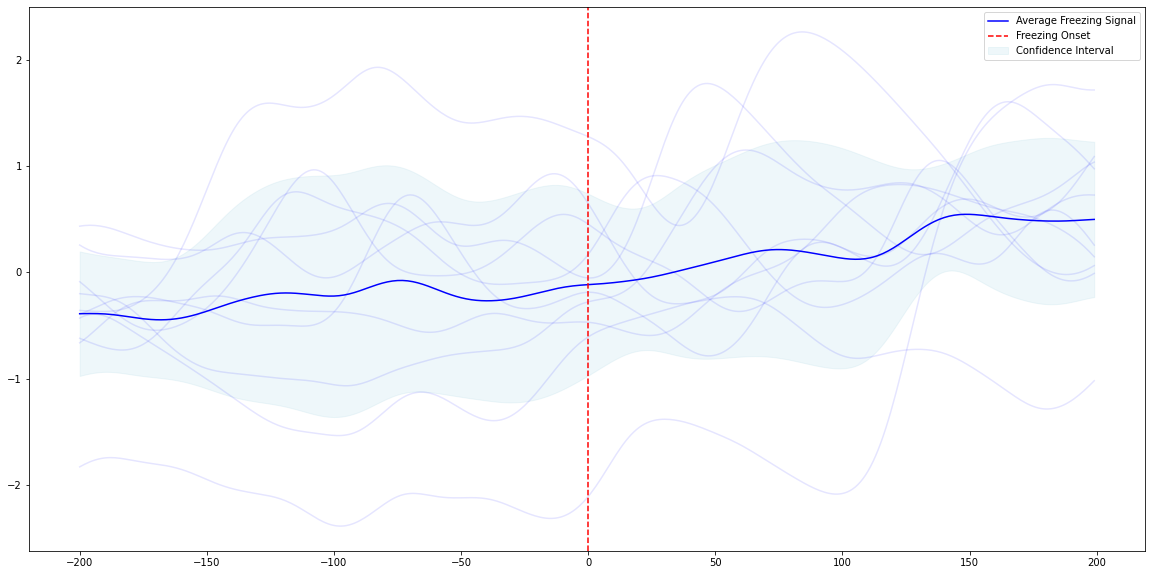

In [30]:
# plot the signals with alpha=0.1
# also plot the average signal

# arange from - off to off
x = np.arange(-off, off)
plt.figure(figsize=(20, 10))
for interval in interval_signals:
    plt.plot(x, interval, color='blue', alpha=0.1)

average_signal = np.mean(interval_signals, axis=0)
plt.plot(x, average_signal, color='blue', label='Average Freezing Signal')
# make a line for the onset
plt.axvline(x=0, color='red', linestyle='--', label='Freezing Onset')
# plot confidence intervals
std_signal = np.std(interval_signals, axis=0)
plt.fill_between(x, average_signal - std_signal, average_signal + std_signal, color='lightblue', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.show()

In [31]:
np.array(interval_signals)

array([[-1.82980934, -1.81668294, -1.80442358, ...,  1.7172732 ,
         1.71650436,  1.71658404],
       [-0.3920326 , -0.3833615 , -0.37401207, ...,  1.02785075,
         1.00155951,  0.9748254 ],
       [-0.61973591, -0.62953032, -0.63923647, ...,  0.32092618,
         0.28933651,  0.25698879],
       ...,
       [ 0.43478576,  0.43857792,  0.44126995, ...,  1.01205001,
         1.0258677 ,  1.03786086],
       [-0.19977047, -0.20236194, -0.20477151, ...,  0.7298237 ,
         0.72930355,  0.72798302],
       [-0.08711031, -0.10620765, -0.12602982, ..., -0.03568893,
        -0.02298227, -0.00891637]])

In [32]:
# make a significance test if there is a change at the beginning to the end of the freezing

from scipy.stats import ttest_ind

interval_signals = np.array(interval_signals)
start_signal = np.mean(interval_signals[:,:off], axis=1)
end_signal = np.mean(interval_signals[:,-off:], axis=1)

ttest_ind(start_signal, end_signal)

# the p-value is very low, so we can reject the null hypothesis that the means are the same
# we can assume that there is a significant difference between the start and the end of the freezing


TtestResult(statistic=-1.4970152708586595, pvalue=0.15171919181836913, df=18.0)

In [33]:
start_signal

array([-2.08703174, -0.15405983,  0.05828112,  1.12245402,  0.32886838,
       -0.39333844, -1.10344645,  0.32633136, -0.74806225,  0.12855483])

In [34]:
end_signal

array([-0.61168938,  0.27748414,  0.26386468,  1.09848831, -0.59381525,
        0.21774506,  0.1993859 ,  0.77715998,  0.61488617,  0.16643164])

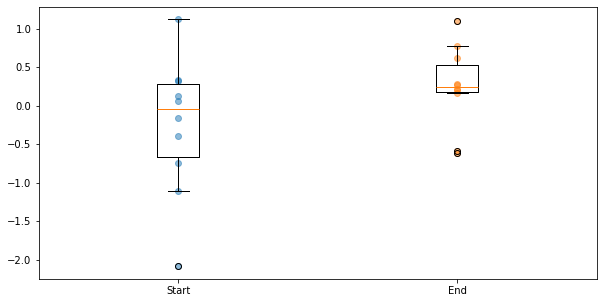

In [35]:
# make box plot that has on the x axis the group 'end' and 'start' and on the y axis the signal value
# show the data points with alpha=0.5

plt.figure(figsize=(10, 5))
plt.boxplot([start_signal, end_signal], labels=['Start', 'End'])
plt.scatter([1] * len(start_signal), start_signal, alpha=0.5)
plt.scatter([2] * len(end_signal), end_signal, alpha=0.5)
plt.show()

In [36]:
# Data:

print(zdFF) # photometry signal
print(interpolated_head_freezing) # freezing signal

[3.53491351 3.53506395 3.53427126 ... 0.13321819 0.13258843 0.13234731]
[False False False ... False False False]
